# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Homework 5 - Recurrent Neural Networks



**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f"The R^2 is {R:.4f}")
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" on the other hand is descriptive).

<hr style="height:2pt">

In [2]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

plt.style.use("tableau-colorblind10")

print(f"Using TensorFlow version: {tf.__version__}")
print(f"Using TensorFlow Keras version: {tf.keras.__version__}")

Using TensorFlow version: 2.4.1
Using TensorFlow Keras version: 2.4.0


In [3]:
devices = tf.config.experimental.get_visible_devices()
print(f"Devices: {devices}\n")
print(
    f"Logical Devices: {tf.config.experimental.list_logical_devices('GPU')}\n"
)

print(f"GPU Available: {tf.config.list_physical_devices('GPU')}\n")
print(f"All Pysical Devices: {tf.config.list_physical_devices()}")

# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Logical Devices: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

All Pysical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<a id="contents"></a>

## Notebook Contents

- [**PART 1 [ 22 pts ]: Data**](#part1)
  - [Overview](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [ 38 pts ]: Modelling**](#part2)
  - [Overview](#part2intro)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


- [**PART 3 [ 40 pts ]: Analysis**](#part3)
  - [Overview](#part3intro)
  - [Questions](#part3questions)
  - [Solutions](#part3solutions)


## About this Homework

### The named entity recognition challenge!

[**Named entity recognition (NER)**](https://en.wikipedia.org/wiki/Named-entity_recognition) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora, and content-based recommendation systems. 

NER represents an interesting "many-to-many" problem, and in this homework, it allows us to experiment with recurrent architectures and compare their performances against other models.

<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [ 22 pts ]: Data

[Return to contents](#contents)


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

**First, we will read `data/HW5_data.csv` into a pandas dataframe using the code provided below:**

In [4]:
# RUN THIS CELL
datapath = "./data/HW5_data.csv"
data = pd.read_csv(datapath, encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


**As you can see above,** we have a dataset with sentences (as indicated by the `Sentence #` column), each composed of words (shown in the `Word` column) with part-of-speech tagging (shown in the `POS` tagging column) and inside–outside–beginning (IOB) named entity tags attached (shown in the `Tag` column). **`POS` will NOT be used for this homework. We will predict `Tag` using only the words themselves.**

**Essential info about entities:**

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

**IOB prefix:**

* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<a id="part1questions"></a>

### <div class='exercise'>PART 1: Questions</div> 

[Return to contents](#contents)

<a id="q11"></a>

**[1.1:](#s11)** Create a list of unique words found in the `Word` column and sort it in alphabetic order (do not modify the word capitalization, nor remove any numeric or special characters). Then append the special word `"ENDPAD"` to the end of the list, and assign it to the variable `words`. Store the length of this list as `n_words`. **Print your results for `n_words`**

<a id="q12"></a>

**[1.2:](#s12)** Create a list of unique tags and sort it in alphabetic order. Then append the special word `"PAD"` to the end of the list, and assign it to the variable `tags`. Store the length of this list as `n_tags`. **Print your results for `n_tags`**

<a id="q13"></a>

**[1.3:](#s13)** Create a list of lists where each sentence in the data is a list of `(word, tag)` tuples. Here is an example of how the first sentence in the list should look:

```
[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'),
('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'),
('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'),
('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), 
('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'),
('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]
```

<a id="q14"></a>

**[1.4:](#s14)**  Find out the number of words in the longest sentence, and store it to variable `max_len`. **Print your results for `max_len`.**

<a id="q15"></a>

**[1.5:](#s15)** It is now time to convert the sentences data in a suitable format for our RNN training and evaluation procedures. Create a `word2idx` dictionary that maps distinct words from the dataset into distinct integers. Also create an `idx2word` dictionary.

<a id="q16"></a>

**[1.6:](#s16)** Prepare the predictors matrix `X` as a list of lists, where each inner list is a sequence of words mapped into integers according to the `word2idx` dictionary. 

<a id="q17"></a>

**[1.7:](#s17)** Apply the Keras `pad_sequences` function to create standard length observations. You should retrieve a matrix with all padded sentences and length equal to the `max_len` previously computed. The dimensionality of your resulting `X` matrix should therefore be equal to `(# of sentences, max_len)`. Run the provided cell to print your results. Your `X[i]` now should be something similar to this:

```
 [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]
```
 
<a id="q18"></a>

**[1.8:](#s18)** Create a `tag2idx` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a `idx2tag` dictionary.

<a id="q19"></a>

**[1.9:](#s19)** Prepare the targets matrix `Y` as a list of lists, where each inner list is a sequence of tags mapped into integers according to the `tag2idx` dictionary.

<a id="q110"></a>

**[1.10:](#s110)** Apply the Keras `pad_sequences` function to standardize the targets. Inject the `PAD` tag integer value for the padding words. Your result should be a `Y` matrix with all padded sentences' tags and length equal to the `max_len` previously computed. 

<a id="q111"></a>

**[1.11:](#s111)** Use the Keras `to_categorical` function to one-hot-encode the tags. The dimensionality of your resulting `Y` matrix should be equal to `(# of sentences, max_len, n_tags)`. Run the provided cell to print your results.

<a id="q112"></a>

**[1.12:](#s112)** Split the dataset into train and test sets with a 10% test split using `109` for your random state. Assign your training data to the variables `X_tr` and `y_tr` and your test data to the variables `X_te` and `y_te`.

<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)

<a id="s11"></a>
<div class='exercise-r'>  

**[1.1:](#q11)** Create a list of unique words found in the `Word` column and sort it in alphabetic order (do not modify the word capitalization, nor remove any numeric or special characters). Then append the special word `"ENDPAD"` to the end of the list, and assign it to the variable `words`. Store the length of this list as `n_words`. **Print your results for `n_words`**

</div>

In [5]:
# your code here
words = sorted(np.unique(data['Word']))
words.append('ENDPAD')
n_words = len(words)

In [6]:
# Run this cell to show your results for n_words
print("There are {:,} unique words found in our dataset.".format(n_words))

There are 35,179 unique words found in our dataset.


<a id="s12"></a>
<div class='exercise-r'>  

**[1.2:](#q12)** Create a list of unique tags and sort it in alphabetic order. Then append the special word `"PAD"` to the end of the list, and assign it to the variable `tags`. Store the length of this list as `n_tags`. **Print your results for `n_tags`**

</div>

In [7]:
# your code here
tags = list(sorted(np.unique(data['Tag'])))
tags.append("PAD")
n_tags = len(tags)

In [8]:
# Run this cell to show your results for n_tags
print("There are {} unique tags found in our dataset.".format(n_tags))

There are 18 unique tags found in our dataset.


<a id="s13"></a>
<div class='exercise-r'>  

**[1.3:](#q13)** Create a list of lists where each sentence in the data is a list of `(word, tag)` tuples. Here is an example of how the first sentence in the list should look:

```
[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'),
('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'),
('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'),
('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), 
('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'),
('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]
```

</div>

In [9]:
# your code here
sentences = []
data['Sentence number'] = data['Sentence #'].apply(lambda x: int(x.split(':')[1]))
grouping = data.groupby('Sentence number')
grouped_word = grouping['Word']
grouped_tag = grouping['Tag']
for word, tag in zip(grouped_word, grouped_tag):
    sentences.append([(w, t) for (w, t) in zip(word[1].values, tag[1].values)])

<a id="s14"></a>
<div class='exercise-r'>  

**[1.4:](#q14)** Find out the number of words in the longest sentence, and store it to variable `max_len`. **Print your results for `max_len`.**

</div>

In [10]:
# your code here
counts = data.groupby('Sentence #').count()['Word']
max_len = counts.max()

In [11]:
# Run this cell to show your results for max_len
print("The number of words in our longest sentence is: {}".format(max_len))

The number of words in our longest sentence is: 104


<a id="s15"></a>
<div class='exercise-r'>  

**[1.5:](#q15)** It is now time to convert the sentences data in a suitable format for our RNN training and evaluation procedures. Create a `word2idx` dictionary that maps distinct words from the dataset into distinct integers. Also create an `idx2word` dictionary.

</div>

In [12]:
# your code here
word2idx = {word:i for i, word in enumerate(words)}
idx2word = {i:word for i, word in enumerate(words)}

<a id="s16"></a>
<div class='exercise-r'>  

**[1.6:](#q16)** Prepare the predictors matrix `X` as a list of lists, where each inner list is a sequence of words mapped into integers according to the `word2idx` dictionary.

</div>

In [13]:
# your code here
X = []
for sentence in sentences:
    X.append([word2idx[word[0]] for word in sentence])

<a id="s17"></a>
<div class='exercise-r'>  

**[1.7:](#q17)** Apply the Keras `pad_sequences` function to create standard length observations. You should retrieve a matrix with all padded sentences and length equal to the `max_len` previously computed. The dimensionality of your resulting `X` matrix should therefore be equal to `(# of sentences, max_len)`. Run the provided cell to print your results. Your `X[i]` now should be something similar to this:

```
 [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]
```

</div>

In [14]:
# your code here
X = pad_sequences(X, max_len)

In [15]:
# Run this cell to show your results
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print("The shape of the X array is: {}".format(X.shape))

The index of word 'Harvard' is: 7506

Sentence 1: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0  6283 27700 31967 25619 24853 33246 19981 25517 33246 29399
 34878 19044 18095 34971 32712 31830 17742     1  4114 11464 11631 14985
     1 17364     1 14484 33246  3881    24     1]

The shape of the X array is: (47959, 104)


<a id="s18"></a>
<div class='exercise-r'>  

**[1.8:](#q18)** Create a `tag2idx` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a `idx2tag` dictionary.

</div>

In [16]:
# your code here
tag2idx = {tag:i for i, tag in enumerate(tags)}
idx2tag = {i:tag for i, tag in enumerate(tags)}

<a id="s19"></a>
<div class='exercise-r'>  

**[1.9:](#q19)** Prepare the targets matrix `Y` as a list of lists, where each inner list is a sequence of tags mapped into integers according to the `tag2idx` dictionary.

</div>

In [17]:
# your code here
Y = []
for sentence in sentences:
    Y.append([tag2idx[word[1]] for word in sentence])

<a id="s110"></a>
<div class='exercise-r'>  

**[1.10:](#q110)** Apply the Keras `pad_sequences` function to standardize the targets. Inject the `PAD` tag integer value for the padding words. Your result should be a `Y` matrix with all padded sentences' tags and length equal to the `max_len` previously computed.

</div>

In [18]:
# your code here
Y = pad_sequences(Y, max_len, value = tag2idx['PAD'])

In [19]:
print("The shape of the Y array is: {}".format(Y.shape))

The shape of the Y array is: (47959, 104)


<a id="s111"></a>
<div class='exercise-r'>  

**[1.11:](#q111)** Use the Keras `to_categorical` function to one-hot-encode the tags. The dimensionality of your resulting `Y` matrix should be equal to `(# of sentences, max_len, n_tags)`. Run the provided cell to print your results.

</div>

In [20]:
# your code here
Y = to_categorical(Y)

In [21]:
# Run this cell to show your results
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print("The shape of the Y array is: {}".format(Y.shape))

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

The shape of the Y array is: (47959, 104, 18)


<a id="s112"></a>
<div class='exercise-r'>  

**[1.12:](#q112)** Split the dataset into train and test sets with a 10% test split using `109` for your random state. Assign your training data to the variables `X_tr` and `y_tr` and your test data to the variables `X_te` and `y_te`.

</div>

In [23]:
# your code here
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.1, random_state=109)

In [24]:
# Run this cell to show your results
print(
    "The shapes of the resulting train-test splits are:\n\n"
    "\tX_train\t{}\n\ty_train\t{}\n\n\tX_test\t{}\n\ty_test\t{}\n"
    "".format(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)
)

The shapes of the resulting train-test splits are:

	X_train	(43163, 104)
	y_train	(43163, 104, 18)

	X_test	(4796, 104)
	y_test	(4796, 104, 18)



<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [ 38 pts ]: Modelling

[Return to contents](#contents)


<a id="part2intro"></a>

## Overview

[Return to contents](#contents)

**After preparing the train and test sets, we are ready to build five models:**

1. Frequency-based (Baseline) 
2. Feed forward neural network (FNN)
3. Recurrent neural network (RNN)
4. Gated recurrent neural network (GRU)
5. Bidirectional gated recurrent neural network (Bidirectional GRU)

More details are given about the desired architectures in each model's section in [PART 2: Questions](#part2questions) below. The input and output dimensions (i.e. the shapes of the inputs and outputs) will be the same for all models:

- input: `[# of sentences, max_len]`
- output: `[# of sentences, max_len, n_tags]`

Follow the information in each model's section to set up the architecture of the model. And, after training each model, use the given `store_keras_model` function to store the weights and architectures in the `./models` path for later testing. A `load_keras_model` function is also provided to you.

A further `plot_training_history` helper function is given to illustrate the training history.

**Here are the provided helper functions described above:**

In [32]:
# RUN THIS CELL

# Store model
def store_keras_model(model, model_name):
    """Save model and weights as model_name in models folder
    
    :param model: trained Keras model object
    :param model_name: str, name under which to save the model
    """
    # serialize model to JSON
    model_json = model.to_json()
    if not os.path.exists("models"):
        os.mkdir("models")
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("./models/{}.h5".format(model_name))
    print("Saved model to disk")


# Load model 
def load_keras_model(model_name):
    """Load model_name from models folder in working directory
    
    :param model_name: str, name of saved model
    :return: Keras model object loaded from disk
    """
    # Load json and create model
    json_file = open("./models/{}.json".format(model_name), "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model


# Plot history
def plot_training_history(
    history, model_title, loss_name="Categorical Cross-entropy"
):
    """Plot training and validation loss over all trained epochs
    
    :param history: Keras model training history object
    :param model_title: str, descriptive model name for use in plot title
    :param loss_name: str, name of loss type used in model for labeling
                      y-axis (default="Categorical Cross-entropy")
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1,len(loss)+1)

    fig, ax = plt.subplots(figsize=(7,4))
    plt.plot(epochs, loss, "k--", label="Training loss")
    plt.plot(epochs, val_loss, "ko-", label="Validation loss")
    plt.title(
        "{}\nTraining and Validation Loss".format(model_title), fontsize=14
    )
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("{}".format(loss_name), fontsize=12)
    if len(loss)<31:
        plt.xticks(range(1,len(loss)+1))
    plt.grid(":", alpha=0.4)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show();

<a id="part2questions"></a>

### <div class='exercise'>PART 2: Questions</div> 
Predict the named entity tag of a word to be its most frequently-seen tag in the training set.
[Return to contents](#contents)

<a id="q21"></a>

**[2.1:](#s21)** **MODEL 1: Baseline**

Predict the named entity tag of a word to be its most frequently-seen tag in the training set.

- For example, let's say the word "Apple" appears 10 times in the training set and 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, our Baseline model should predict it as "Corporate".

**Create an np.array `baseline` of length [n_words]** where the $i$-th element `baseline[i]` is the index of the most commonly seen named entity tag of word $i$ summarized from the training set (e.g. `[16, 16, 16, ..., 0, 16, 16]`). For words that aren't present in the training set, use the default tag `"O"`.


<a id="q22"></a>

**[2.2:](#s22)** **MODEL 2: Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input and output dimensionalities and the Embedding layer.

<a id="q22a"></a>

- **[2.2.a:](#s22a)** Explain what the Embedding layer is and why we need it here.

<a id="q22b"></a>

- **[2.2.b:](#s22b)** Explain why the Param # of the Embedding layer is 1,758,950 (as shown in `print(model.summary())`).

<a id="q22c"></a>

- **[2.2.c:](#s22c)** In addition to our models' final results, we often want to inspect intermediate results. For this, we can get outputs from a hidden layer and reduce the dimensionality of those outputs using PCA so that we can visualize them in 2-dimensional space.
  - Using the code provided to you in this question, visualize outputs from the Embedding layer in your feed-forward neural network, with one subplot for **B-tags** and one subplot for **I-tags**. (Please note that you should be able to generate these plots by simply running the code provided to you.)
  - Comment on the patterns you observe in the plotted output.

<a id="q23"></a>

**[2.3:](#s23)** **MODEL 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

  - an Input "layer"
  - a simple Embedding layer transforming integer words into vectors
  - a Dropout layer to regularize the model
  - a SimpleRNN layer
  - a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to `n_tag`
    
For hyperparameters in this model as well as the subsequent models in 2.4 and 2.5, please use those provided to you in MODEL 2.


<a id="q23a"></a>

- **[2.3.a:](#s23a)** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.


<a id="q23b"></a>

- **[2.3.b:](#s23b)** Using the functions provided to you [in 2.2.c](#s22c), visualize outputs from the SimpleRNN layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.


<a id="q24"></a>

**[2.4:](#s24)** **MODEL 4: GRU**


<a id="q24"></a>

- **[2.4.a:](#s24a)** Briefly explain what a GRU is and how it is different from a simple RNN.


<a id="q24b"></a>

- **[2.4.b:](#s24b)** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.


<a id="q24c"></a>

- **[2.4.c:](#s24c)** Using the functions provided to you [in 2.2.c](#s22c), visualize outputs from the GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.


<a id="q25"></a>

**[2.5:](#s25)** **MODEL 5: Bidirectional GRU**

<a id="q25a"></a>

- **[2.5.a:](#s25a)** Explain how a Bidirectional GRU differs from the GRU model above.


<a id="q25b"></a>

- **[2.5.b:](#s25b)** Define, compile, and train a Bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


<a id="q25c"></a>

- **[2.5.c:](#s25c)**  Using the functions provided to you [in 2.2.c](#s22c), visualize outputs from the Bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

<a id="part2solutions"></a>

## PART 2: Solutions

[Return to contents](#contents)

<a id="s21"></a>
<div class='exercise-r'>  

**[2.1:](#q21)** **MODEL 1: Baseline**

Predict the named entity tag of a word to be its most frequently-seen tag in the training set.

- For example, let's say the word "Apple" appears 10 times in the training set and 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, our Baseline model should predict it as "Corporate".

**Create an np.array `baseline` of length [n_words]** where the $i$-th element `baseline[i]` is the index of the most commonly seen named entity tag of word $i$ summarized from the training set (e.g. `[16, 16, 16, ..., 0, 16, 16]`). For words that aren't present in the training set, use the default tag `"O"`.

</div>

In [25]:
# your code here
from collections import Counter

words_to_tags = {}
for sentence in sentences:
    for word in sentence:
        if words_to_tags.get(word[0]) is None:
            words_to_tags[word[0]] = [word[1]]
        else:
            words_to_tags[word[0]].append(word[1])

for word in words_to_tags:
    counter = Counter(words_to_tags[word])
    most_frequent_tag = list(counter.keys())[0]
    words_to_tags[word] = most_frequent_tag
    
baseline = []
for index in range(n_words):
    word = idx2word.get(index)
    most_frequent_tag_index = words_to_tags.get(word, None)
    if most_frequent_tag_index is None:
        baseline.append('O')
    else:
        baseline.append(int(tag2idx.get(most_frequent_tag_index)))

baseline = np.array(baseline)

In [26]:
# Run this cell to show your results
print("The baseline array is shape: {}".format(baseline.shape))
print(
    "The training predictions array is shape: {}\n".format(baseline[X_tr].shape)
)
print("Sentence:\n {}\n".format([idx2word[w] for w in X_tr[0]]))
print("Predicted Tags:\n {}".format([idx2tag[int(i)] for i in baseline[X_tr[0]]]))

The baseline array is shape: (35179,)
The training predictions array is shape: (43163, 104)

Sentence:
 ['!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', 'Mr.', 'Abbas', 'heads', 'the', 'Fatah', 'faction', ',', 'which', 'is', 'a', 'fierce', 'rival', 'of', 'Hamas', '.']

Predicted Tags:
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

<a id="s22"></a>
<div class='exercise-r'>  

**[2.2:](#q22)** **MODEL 2: Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input and output dimensionalities and the Embedding layer.

</div>

### Use these hyperparameters for all NN models

In [27]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [28]:
# Define model
model_title = "Feed-forward Neural Network (FFNN)"
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Embedding(
        input_dim=n_words, output_dim=dim_embed, input_length=max_len
    )
)
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [29]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
%%time
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 9s 6ms/step - loss: 0.8764 - accuracy: 0.9433 - val_loss: 0.0626 - val_accuracy: 0.9851
Epoch 2/10
1214/1214 [==============================] - 7s 6ms/step - loss: 0.0538 - accuracy: 0.9863 - val_loss: 0.0503 - val_accuracy: 0.9862
Epoch 3/10
1214/1214 [==============================] - 7s 6ms/step - loss: 0.0459 - accuracy: 0.9870 - val_loss: 0.0476 - val_accuracy: 0.9869
Epoch 4/10
1214/1214 [==============================] - 7s 6ms/step - loss: 0.0426 - accuracy: 0.9878 - val_loss: 0.0462 - val_accuracy: 0.9872
Epoch 5/10
1214/1214 [==============================] - 7s 6ms/step - loss: 0.0413 - accuracy: 0.9881 - val_loss: 0.0454 - val_accuracy: 0.9873
Epoch 6/10
1214/1214 [==============================] - 7s 6ms/step - loss: 0.0399 - accuracy: 0.9886 - val_loss: 0.0448 - val_accuracy: 0.9874
Epoch 7/10
1214/1214 [==============================] - 7s 6ms/step - loss: 0.0393 - accuracy: 0.9888 - val_loss: 0.0445 - val_accuracy:

In [33]:
store_keras_model(model, "model_FFNN")

Saved model to disk


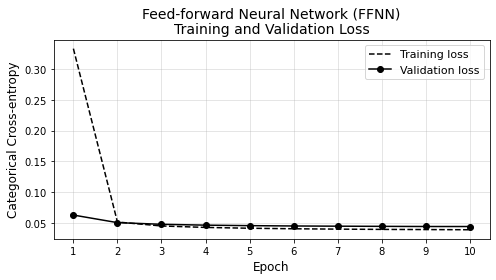

In [34]:
plot_training_history(history, model_title)

<a id="s22a"></a>
<div class='exercise-r'>  

**[2.2.a:](#q22a)** Explain what the Embedding layer is and why we need it here.

</div>

**INTERPRETATION:**

An embedding layer is a 'representational layer'. It projects the inputs into a lower dimension in order to benefit from a better representation of our inputs. 

*Why is it better ?* Our initial input is sparse, padded and not normalized (with numbers between 1 and 35000). Projecting this input into a lower dimension space (here $50$) will present several advantages:
- Benefit from representations in space with lower dimension. This allows us to leverage Dense layers without having to use tens of millions of parameters. Indeed, suppose we had a dense layer with 500 hidden units before the output layer: the number of parameters would have been $35000*500 + 500*16$ (let aside bias) which would be far greater
- Benefit from **dense representations**. Our initial representations were quite sparse, because of the padding. Using an Embedding layer will allow us to benefit from more dense representations
- Have a representation for the input words: this embedding layer could serve for other downstream tasks
- Projecting the inputs into a lower dimensional space allows us to have some better performances for our model (should the dimension of the embedding be well chosen)

<a id="s22b"></a>
<div class='exercise-r'>  

**[2.2.b:](#q22b)** Explain why the Param # of the Embedding layer is 1,758,950 (as shown in `print(model.summary())`).

</div>

**INTERPRETATION:**

The effect of the embedding layer is projecting the input in a subspace. Therefore, its action is $H = U^TX$, where the shape of $U$ is $(n_{words}, dim_{embed})$

In [35]:
n_words*dim_embed

1758950

<a id="s22c"></a>
<div class='exercise-r'>  

**[2.2.c:](#q22c)** In addition to our models' final results, we often want to inspect intermediate results. For this, we can get outputs from a hidden layer and reduce the dimensionality of those outputs using PCA so that we can visualize them in 2-dimensional space.
  - Using the code provided to you in this question, visualize outputs from the Embedding layer in your feed-forward neural network, with one subplot for **B-tags** and one subplot for **I-tags**. (Please note that you should be able to generate these plots by simply running the code provided to you.)
  - Comment on the patterns you observe in the plotted output.
</div>

In [36]:
def get_hidden_output_PCA(
    model, X_test, layer_index, out_dimension, model_title
):
    """Generate hidden layer output PCA transformation
    
    Captures the output of a specific layer in a Keras model and then 
    returns a transformed PCA object. Also, prints the variance explained 
    by the first two principal components.  
    
    :param model: Keras trained model object
    :param X_test: np.array, X test data
    :param layer_index: int, index of model layer for which to inspect output
    :param out_dimension: int, output embedding dimension of chosen layer
    :param model_title: str, descriptive model name for use in printed output
    :return: Fitted and transformed sklearn PCA model object
    """
    output = tf.keras.backend.function(
        [model.layers[0].input],[model.layers[layer_index].output]
    )
    hidden_feature = np.array(output([X_test]))
    hidden_feature = hidden_feature.reshape(-1, out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print(
        "{}\nHidden features' variance explained by PCA first 2 "
        "components: {:.4f}\n".format(
            model_title, np.sum(pca.explained_variance_ratio_)
        )
    )
    return pca_result

In [37]:
def visualize_B_I(pca_result, y_test, model_title):
    """Visualize the first 2 PCA dimensions, labeled by tag
    
    Constructs two subplots showing the first two principal components of
    the `B-tags` and `I-tags` in the transformed PCA object provided
    
    :param pca_result: sklearn PCA object
    :param y_test: np.array, y test data
    :param model_title: str, descriptive model name for use in plot title
    """
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11, 6.5)) 
    titles=["B-tags", "I-tags"]
    
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(
                pca_result[indices,0],
                pca_result[indices, 1],
                label=idx2tag[cat],
                s=10,
                alpha=0.6,
            )
        ax[i].legend(markerscale=2, facecolor="w", framealpha=1, fontsize=11)
        ax[i].grid(":", alpha=0.4)
        ax[i].set_xlabel("First principal component", fontsize=12)
        ax[i].set_title(titles[i], fontsize=14)
    
    ax[0].set_ylabel("Second principal component", fontsize=12)
    fig.suptitle(
        "Visualization of hidden features on first two PCA components:\n"
        "{}".format(model_title),
        fontsize=16,
        y=1,
        )
    
    plt.tight_layout()
    plt.show()

Feed-forward Neural Network (FFNN)
Hidden features' variance explained by PCA first 2 components: 0.9286



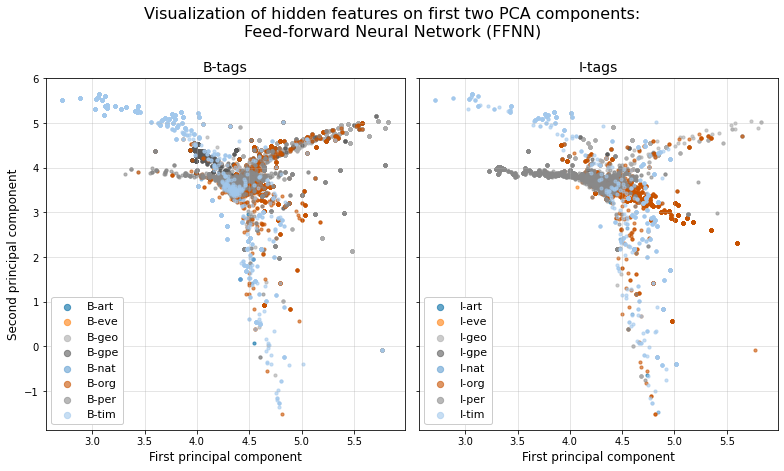

In [38]:
# Run this cell to show your results
FFNN = load_keras_model("model_FFNN")
h_pca = get_hidden_output_PCA(FFNN, X_te, 1, 50, model_title)
visualize_B_I(h_pca, y_te, model_title)

**INTERPRETATION:**

We can see that, among a tag ($B$ or $I$), the different tags are quite well separated. However, the related labels between $I$ and $B$ tags are quite similar in the embedding layer, which tells us that the network relies on the combination between the different features in order to make a prediction.

<a id="s23"></a>
<div class='exercise-r'>  

**[2.3:](#q23)** **MODEL 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

  - an Input "layer"
  - a simple Embedding layer transforming integer words into vectors
  - a Dropout layer to regularize the model
  - a SimpleRNN layer
  - a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to `n_tag`
    
For hyperparameters in this model as well as the subsequent models in 2.4 and 2.5, please use those provided to you in MODEL 2.

<a id="s23a"></a>

- **[2.3.a:](#q23a)** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

</div>


In [39]:
# your code here
model = tf.keras.Sequential()
# model.add(tf.keras.layers.InputLayer(input_shape=(104,), batch_size=batch_size))
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(SimpleRNN(units=100, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [41]:
# Run this cell to save your model
store_keras_model(model, "model_RNN")

Saved model to disk


In [42]:
# Run this cell to show your results
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 100)          15100     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


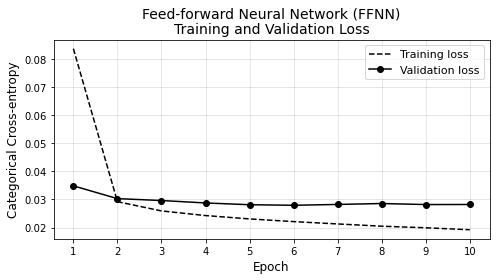

In [43]:
# Run this cell to show your results
plot_training_history(history, model_title)

<a id="s23b"></a>
<div class='exercise-r'>  

**[2.3.b:](#q23b)** Using the functions provided to you [in 2.2.c](#s22c), visualize outputs from the SimpleRNN layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

</div>

Recurrent Neural Network (RNN)
Hidden features' variance explained by PCA first 2 components: 0.7679



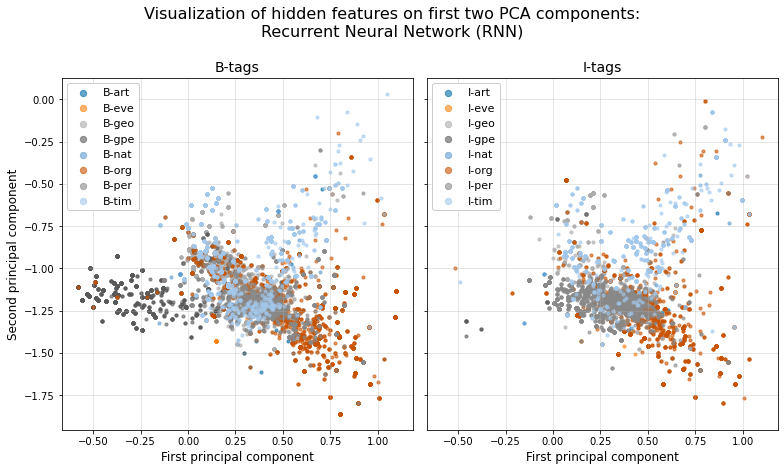

In [44]:
# your code here
RNN = load_keras_model("model_RNN")
h_pca = get_hidden_output_PCA(RNN, X_te, 1, 50, "Recurrent Neural Network (RNN)")
visualize_B_I(h_pca, y_te, "Recurrent Neural Network (RNN)")

**INTERPRETATION:**

*Your answer here*


<a id="s24"></a>
<div class='exercise-r'>  

**[2.4:](#q24)** **MODEL 4: GRU**

<a id="s24a"></a>

- **[2.4.a:](#q24a)** Briefly explain what a GRU is and how it is different from a simple RNN.

</div>

**INTERPRETATION:**

The GRU comes from the observation that RNNs are not able to capture long term dependencies in long sequences. The reason for that is the instability when backpropagating the information. 

GRU allows the network to select what he wants to retain/forget thanks to a gated mechanism. It leverages two gates: a reset gate and an update gate.  The reset gate allows to produce a new candidate for the memory and the update gate produces a score in order to compute how much we want to retain from our previous memory. 

What is crucially different from the RNNs is the update of the hidden state: there is a leaky unit allowing the information to flow more easily and therefore prevent the numerical instabilities when passing some information.

<a id="s24b"></a>
<div class='exercise-r'>  

**[2.4.b:](#q24b)** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

</div>

In [45]:
# your code here
model = tf.keras.Sequential()
# model.add(tf.keras.layers.InputLayer(input_shape=(104,), batch_size=batch_size))
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(GRU(units=100, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [46]:
%%time
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 19s 10ms/step - loss: 0.2282 - accuracy: 0.9558 - val_loss: 0.0337 - val_accuracy: 0.9901
Epoch 2/10
1214/1214 [==============================] - 12s 10ms/step - loss: 0.0290 - accuracy: 0.9913 - val_loss: 0.0300 - val_accuracy: 0.9911
Epoch 3/10
1214/1214 [==============================] - 12s 10ms/step - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.0290 - val_accuracy: 0.9914
Epoch 4/10
1214/1214 [==============================] - 12s 10ms/step - loss: 0.0239 - accuracy: 0.9929 - val_loss: 0.0281 - val_accuracy: 0.9917
Epoch 5/10
1214/1214 [==============================] - 12s 10ms/step - loss: 0.0225 - accuracy: 0.9933 - val_loss: 0.0274 - val_accuracy: 0.9918
Epoch 6/10
1214/1214 [==============================] - 12s 10ms/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.0269 - val_accuracy: 0.9919
Epoch 7/10
1214/1214 [==============================] - 12s 10ms/step - loss: 0.0202 - accuracy: 0.9939 - val_loss: 0.0271 -

In [47]:
# Run this cell to save your model
store_keras_model(model, "model_GRU")

Saved model to disk


In [48]:
# Run this cell to show your results
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


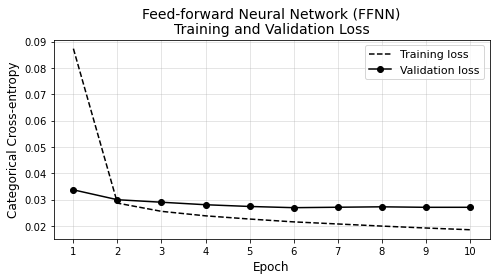

In [49]:
# Run this cell to show your results
plot_training_history(history, model_title)

<a id="s24c"></a>
<div class='exercise-r'>  

**[2.4.c:](#q24c)** Using the functions provided to you [in 2.2.c](#s22c), visualize outputs from the GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

</div>

Gated Recurrent Unit (GRU)
Hidden features' variance explained by PCA first 2 components: 0.7513



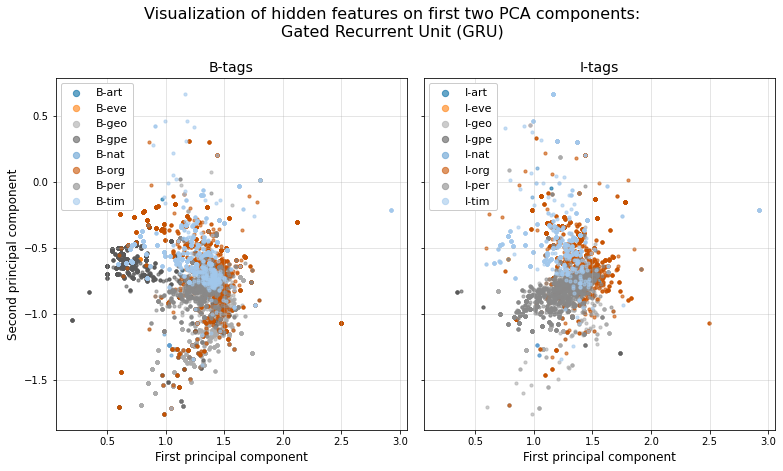

In [50]:
# your code here
GRU = load_keras_model("model_GRU")
h_pca = get_hidden_output_PCA(GRU, X_te, 1, 50, "Gated Recurrent Unit (GRU)")
visualize_B_I(h_pca, y_te, "Gated Recurrent Unit (GRU)")


**INTERPRETATION:**

*Your answer here*


<a id="s25"></a>
<div class='exercise-r'>  

**[2.5:](#q25)** **MODEL 5: Bidirectional GRU**

<a id="s25a"></a>

- **[2.5.a:](#q25a)** Explain how a Bidirectional GRU differs from the GRU model above.

</div>

**INTERPRETATION:**

In a GRU model, we still process the inputs in a sequential way, meaning that $h_t = f(x_t, h_{t-1})$ and then $y_t  = g(x_t, h_{t-1})$. But then, Bi-Directional structures have leveraged the fact that one would also want to use the information coming after the sequence. 

THerefore, in the Bi-directional GRU, we use two GRUs: one forward (when at time $t$, the hidden state is a function of $(h_{1:t-1})$) and one backward, (when at time $t$, the hidden state is a function of $(h_{t+1:T})$).

Last, the resulting hidden state on the bi-directional GRU is the concatenation of both hidden states from both networks.

<a id="s25b"></a>
<div class='exercise-r'>  

**[2.5.b:](#q25b)** Define, compile, and train a Bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

</div>

In [51]:
# your code here
model = tf.keras.Sequential()
# model.add(tf.keras.layers.InputLayer(input_shape=(104,), batch_size=batch_size))
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Bidirectional(layer = tf.keras.layers.GRU(units=100, return_sequences=True))) # concat by default
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [52]:
%%time
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 21s 15ms/step - loss: 0.1844 - accuracy: 0.9607 - val_loss: 0.0297 - val_accuracy: 0.9914
Epoch 2/10
1214/1214 [==============================] - 18s 15ms/step - loss: 0.0246 - accuracy: 0.9928 - val_loss: 0.0252 - val_accuracy: 0.9924
Epoch 3/10
1214/1214 [==============================] - 18s 15ms/step - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.0243 - val_accuracy: 0.9929
Epoch 4/10
1214/1214 [==============================] - 18s 15ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0233 - val_accuracy: 0.9931
Epoch 5/10
1214/1214 [==============================] - 18s 15ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0231 - val_accuracy: 0.9932
Epoch 6/10
1214/1214 [==============================] - 18s 15ms/step - loss: 0.0159 - accuracy: 0.9953 - val_loss: 0.0227 - val_accuracy: 0.9933
Epoch 7/10
1214/1214 [==============================] - 18s 15ms/step - loss: 0.0148 - accuracy: 0.9955 - val_loss: 0.0231 -

In [53]:
# Run this cell to save your model
store_keras_model(model, "model_BiGRU")

Saved model to disk


In [54]:
# Run this cell to show your results
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


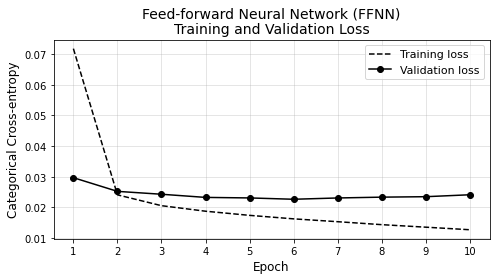

In [55]:
# Run this cell to show your results
plot_training_history(history, model_title)

<a id="s25c"></a>
<div class='exercise-r'>  

**[2.5.c:](#q25c)** Using the functions provided to you [in 2.2.c](#s22c), visualize outputs from the Bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

</div>

Bidirectional Gated Recurrent Unit (BiGRU)
Hidden features' variance explained by PCA first 2 components: 0.8498



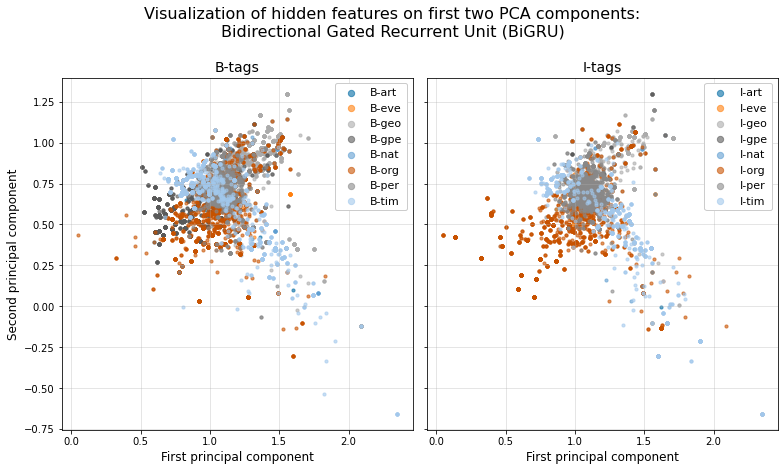

In [56]:
# your code here
BiGRU = load_keras_model("model_BiGRU")
h_pca = get_hidden_output_PCA(BiGRU, X_te, 1, 50, "Bidirectional Gated Recurrent Unit (BiGRU)")
visualize_B_I(h_pca, y_te, "Bidirectional Gated Recurrent Unit (BiGRU)")

**INTERPRETATION:**

*Your answer here*


<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 3 [ 40 pts ]: Analysis

[Return to contents](#contents)


<a id="part3intro"></a>

## Overview

[Return to contents](#contents)

Now that we have built, trained, and visualized our 5 different models, in this section, we will further investigate the results of each model and then seek to improve the results of our most promising model.

For this section, we will be using $F_1$ score as our evaluative metric. If you are unfamiliar with this metric, $F_1$ is the harmonic mean of precision and recall. Some basic background on this metric [can be found here](https://en.wikipedia.org/wiki/F1_score).

<a id="part3questions"></a>

### <div class='exercise'>PART 3: Questions</div> 

[Return to contents](#contents)


<a id="q31"></a>

**[3.1:](#s31)** For each model, iteratively:

- Load the model using the given function `load_keras_model`

- Apply the model to the test dataset

- Compute an $F_1$ score for each `Tag` and store it 


<a id="q32"></a>

**[3.2:](#s32)** Plot the $F_1$ score per Tag and per model, including all on a single grouped barplot. Include a horizontal reference line at $F_1=0.8$ on your plot.


<a id="q33"></a>

**[3.3:](#s33)** Briefly discuss the performance of each model.


<a id="q34"></a>

**[3.4:](#s34)** Which tags have the lowest $F_1$ score? For instance, you may find from the plot above that the test performance on `"B-art"` and `"I-art"` is very low (just an example, your case may be different). Here is an example when models failed to predict these tags right:

<img src="data/B_art.png" alt="drawing" width="600"/>


<a id="q35"></a>

**[3.5:](#s35)** Write functions to output another example test sentence in which the lowest scoring tags you identified in 3.4 were predicted wrong in a sentence (be certain to include both `"B-xxx"` and `"I-xxx"` tags). Store the results in a DataFrame (same format as the above example) and use the styling function provided below to display your DataFrame so that misclassified tags are shown with red text similar to the example provided in the image above. (**Please note:** The red text of your styled DataFrame will not persist between Jupyter notebook sessions. That is perfectly fine and to be expected.)

<a id="q36"></a>

**[3.6:](#s36)** Choose one of the most promising models you have built and improve that model to achieve an $F_1$ score greater than $0.8$ for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of the NN, using a different optimizer, etc.).


<a id="q37"></a>

**[3.7:](#s37)** For your final improved model, illustrate your results with a bar plot similarly formatted to the one you created in 3.2, and be certain to include a horizontal line at $F_1=0.8$ to make interpretation easier. Interpret your results and clearly explain why you chose to change certain elements of the model and how effective those adjustments were.


<a id="part3solutions"></a>

## PART 3: Solutions

[Return to contents](#contents)

<a id="s31"></a>
<div class='exercise-r'>  

**[3.1:](#q31)** For each model, iteratively:

- Load the model using the given function `load_keras_model`

- Apply the model to the test dataset

- Compute an $F_1$ score for each `Tag` and store it

</div>

In [57]:
baseline

array(['16', '16', '16', ..., '15', '16', 'O'], dtype='<U21')

In [59]:
y_test

array([[17, 17, 17, ..., 16, 16, 16],
       [17, 17, 17, ...,  6, 14, 16],
       [17, 17, 17, ..., 16, 16, 16],
       ...,
       [17, 17, 17, ..., 16, 16, 16],
       [17, 17, 17, ...,  5, 16, 16],
       [17, 17, 17, ..., 16, 16, 16]])

In [75]:
y_pred = model(X_te)

In [76]:
y_pred = np.argmax(y_pred, axis=-1)

In [77]:
y_pred

array([[17, 17, 17, ..., 16, 16, 16],
       [17, 17, 17, ..., 13, 13, 16],
       [17, 17, 17, ..., 16, 16, 16],
       ...,
       [17, 17, 17, ..., 16, 16, 16],
       [17, 17, 17, ...,  5, 16, 16],
       [17, 17, 17, ..., 16, 16, 16]])

In [78]:
y_pred.reshape(1, -1)

array([[17, 17, 17, ..., 16, 16, 16]])

In [91]:
# your code here
models = ['model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU']
f1_models = []
y_test = np.argmax(y_te, axis=-1)

for name in models:
    model = load_keras_model(name)
    y_pred = np.argmax(model(X_te), axis=-1)
    f1s = []
    for tag in tag2idx.values():
        y_pred_tag = 1*(y_pred==tag).reshape(1, -1)
        y_true_tag = 1*(y_test==tag).reshape(1, -1)
        f1_tag = f1_score(y_true_tag[0], y_pred_tag[0])
        f1s.append(f1_tag)
    f1_models.append(f1s)
f1_models = np.array(f1_models)

In [92]:
tags_baseline = []
for sentence in X_te:
    for word in sentence:
        tags_baseline.append(int(baseline[word]))
tags_baseline=np.array(tags_baseline)
f1_baseline = []
f1 = f1_score(y_test.reshape(1, -1)[0], tags_baseline, average=None)

<a id="s32"></a>
<div class='exercise-r'>  

**[3.2:](#q32)** Plot the $F_1$ score per Tag and per model, including all on a single grouped barplot. Include a horizontal reference line at $F_1=0.8$ on your plot.

</div>

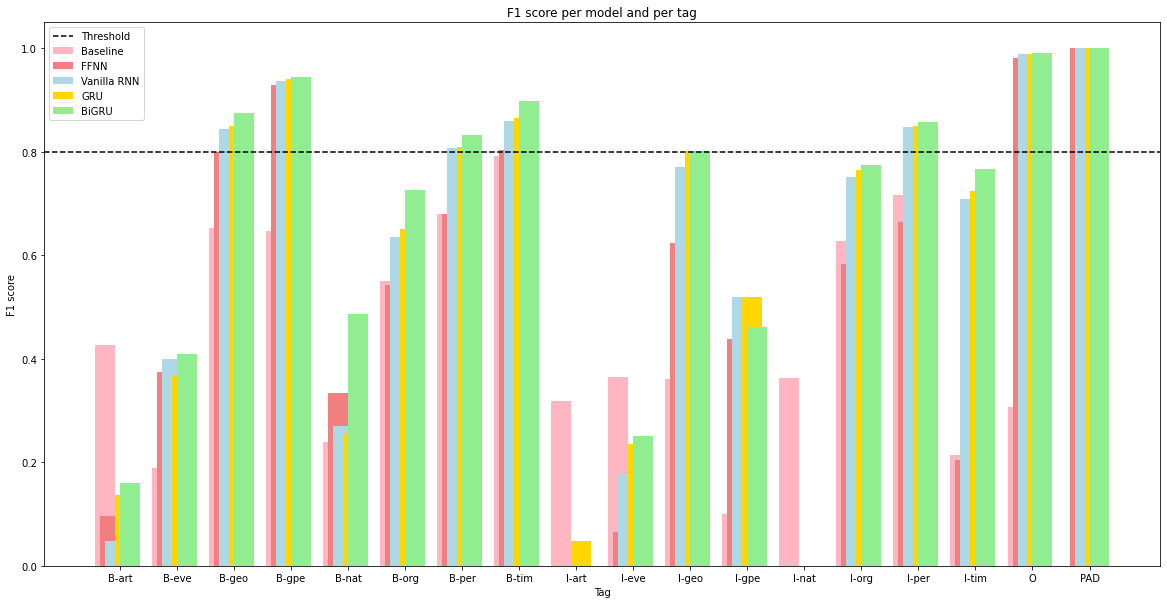

In [93]:
# your code here
fig, ax = plt.subplots(1, figsize=(20, 10))
width = 0.35
labels = list(tag2idx.keys())
x = np.arange(len(labels))
plt.bar(x = x - 3*width/4, height=f1, width=width, color='lightpink', label='Baseline')
plt.bar(x = x - width/2, height=f1_models[0, :], width=width, color='lightcoral', label='FFNN')
plt.bar(x = x - width/4, height=f1_models[1, :], width=width, color='lightblue', label='Vanilla RNN')
plt.bar(x = x + width/4, height=f1_models[2, :], width=width, color='gold', label='GRU')
plt.bar(x = x + width/2, height=f1_models[3, :], width=width, color='lightgreen', label='BiGRU')
ax.set_xticks(x)
ax.axhline(y=0.8, color='k', linestyle='--', label='Threshold')
ax.set_xlabel('Tag')
ax.set_ylabel('F1 score')
ax.set_title('F1 score per model and per tag')
ax.set_xticklabels(labels)
ax.legend()
plt.show(fig)

<a id="s33"></a>
<div class='exercise-r'>  

**[3.3:](#q33)**  Briefly discuss the performance of each model.

</div>

**INTERPRETATION:**

The trends appearing in the previous plot are:
- The Bidirectional GRU is consistently better than all the other models. I guess one could infer that the reason why this happens is because the biGRU has the ability to look at the entire sequence.
- Some classes are so underrespresented that no networks detect them, except the Baseline that uses a rule that does not depend on the representativity of one class. 
- The baseline outperforms the FFNN for a big number of tags. This explains how a naive method can outperform a FFNN, not taking into account the sequential aspect of the problem, thus limited in its predictive power. 
- The GRU wonsistently outperforms the RNN and the BiGRU consistently outperforms the Vanilla RNN and GRUs, which is expected

<a id="s34"></a>
<div class='exercise-r'>  

**[3.4:](#q34)** Which tags have the lowest $F_1$ score? For instance, you may find from the plot above that the test performance on `"B-art"` and `"I-art"` is very low (just an example, your case may be different). Here is an example when models failed to predict these tags right:

<img src="data/B_art.png" alt="drawing" width="600"/>

</div>

**INTERPRETATION:**

The tags that have the lowest $F1$ scores are 'B-art', 'I-art' and 'I-nat'. 

<a id="s35"></a>
<div class='exercise-r'>  

**[3.5:](#q35)** Write functions to output another example test sentence in which the lowest scoring tags you identified in 3.4 were predicted wrong in a sentence (be certain to include both `"B-xxx"` and `"I-xxx"` tags). Store the results in a DataFrame (same format as the above example) and use the styling function provided below to display your DataFrame so that misclassified tags are shown with red text similar to the example provided in the image above. (**Please note:** The red text of your styled DataFrame will not persist between Jupyter notebook sessions. That is perfectly fine and to be expected.)

</div>

In [94]:
def highlight_errors(s):
    """Highlights misclassified values when applied to Pandas styler
    
    See the `pandas.io.formats.style.Styler.apply` documentation
    for more information.
    """
    is_max = s == s.y_true
    return [
        "" if v or key=="Word" else "color: red"
        for key, v in is_max.iteritems()
    ]

In [97]:
y_test

array([[17, 17, 17, ..., 16, 16, 16],
       [17, 17, 17, ...,  6, 14, 16],
       [17, 17, 17, ..., 16, 16, 16],
       ...,
       [17, 17, 17, ..., 16, 16, 16],
       [17, 17, 17, ...,  5, 16, 16],
       [17, 17, 17, ..., 16, 16, 16]])

In [106]:
np.sum(y_test==12)

10

In [103]:
# your code here
selected_sentence = None
indexes_misclassified = set([0, 8, 12])
for i, sentence in enumerate(y_test):
    if indexes_misclassified.issubset(set(sentence)):   # we found a sentence where the 3 tags are present
        y_pred = np.argmax(model.predict(sentence), axis=-1)
        indexes = (sentence == np.array([0, 8, 12]))
        if np.mean(y_pred[indexes] == sentence[indexes]) == 0:
            selected_sentence = sentence
            break

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

In [100]:
print(selected_sentence)

None


<a id="s36"></a>
<div class='exercise-r'>  

**[3.6:](#q36)** Choose one of the most promising models you have built and improve that model to achieve an $F_1$ score greater than $0.8$ for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of the NN, using a different optimizer, etc.).

</div>

In [ ]:
# your code here


<a id="s37"></a>
<div class='exercise-r'>  

**[3.7:](#q37)** For your final improved model, illustrate your results with a bar plot similarly formatted to the one you created in 3.2, and be certain to include a horizontal line at $F_1=0.8$ to make interpretation easier. Interpret your results and clearly explain why you chose to change certain elements of the model and how effective those adjustments were.

</div>

In [ ]:
# your code here


**INTERPRETATION:**

*your answer here*